# ANN hyperparameter evaluation

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline

import itertools
import logging
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from ann_solo import reader, spectral_library
from ann_solo.config import config

In [3]:
tqdm.tqdm = tqdm.tqdm_notebook

# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)    # single-column figure

# initialize logging
logging.basicConfig(format='%(asctime)s [%(levelname)s/%(processName)s] '
                           '%(module)s.%(funcName)s : %(message)s',
                    level=logging.INFO)

In [4]:
splib_filename = '../data/processed/iprg2012/human_yeast_targetdecoy.splib'
mgf_filename = '../data/external/iPRG2012.mgf'
out_dir = '../data/processed/iprg2012'

We consider the following hyperparameters for approximate nearest neighbor (ANN) searching:

- The number of trees in the ANN index.
- The number of nodes in the ANN index to inspect during the search.

Both of these hyperparameters provide a trade-off between speed and accuracy, either at build time or at run time.

For more information about the hyperparameters, please see the [Annoy](https://github.com/spotify/annoy) library.

For each combination of hyperparameters the trade-off between search speed (total time required) and accuracy (number of PSMs at 1% FDR) is evaluated.
The number of identifications for a closed search (precursor mass = 20 ppm) and a traditional, brute-force, open modification search are indicated as a reference.

Search settings:

- Query file: spectra generated for the [iPRG 2012 study](http://www.mcponline.org/cgi/doi/10.1074/mcp.M113.032813).
- Precursor mass tolerance: 300 Da
- Fragment mass tolerance: 0.25 Da

In [5]:
# go through all ANN hyperparameter combinations
num_trees_options = (100, 200, 500, 1000)
search_k_options = (20000, 40000, 100000, 200000, 400000)
for num_trees, search_k in itertools.product(num_trees_options,
                                             search_k_options):
    out_filename = os.path.join(
        out_dir, 'ann_hyperparameters',
        'num_trees_{}-search_k_{}.mztab'.format(num_trees, search_k))
    if not os.path.isfile(out_filename):
        settings = ['--config iprg2012.ini',
                    '--precursor_tolerance_mass_open 300',
                    '--precursor_tolerance_mode_open Da',
                    '--mode ann',
                    '--num_trees {}'.format(num_trees),
                    '--search_k {}'.format(search_k),
                    splib_filename, mgf_filename, out_filename]

        config.parse(' '.join(settings))

        # execute the search
        spec_lib = spectral_library.SpectralLibraryAnnoy(
            config.spectral_library_filename)
        identifications = spec_lib.search(config.query_filename)
        writer.write_mztab(identifications, config.out_filename,
                           spec_lib._library_reader)
        spec_lib.shutdown()

In [6]:
def extract_time_from_log(filename):
    with open(filename, 'r') as f_in:
        for line in f_in:
            if line.startswith('user'):
                # user time
                usertime = line.split()[1]
                minutes = int(usertime[:usertime.find('m')])
                seconds = float(usertime[usertime.find('m') + 1: usertime.rfind('s')])
                usertime = minutes * 60 + seconds
                # sys time
                line = next(f_in)
                systime = line.split()[1]
                minutes = int(systime[:systime.find('m')])
                seconds = float(systime[systime.find('m') + 1: systime.rfind('s')])
                systime = minutes * 60 + seconds
                
                return usertime + systime

In [7]:
pattern_hyperparameters_psms = re.compile('^num_trees_(\d+)-search_k_(\d+).mztab$')
pattern_hyperparameters_log = re.compile('^num_trees_(\d+)-search_k_(\d+).log$')

filename_results = os.path.join(
    out_dir, 'ann_hyperparameters', 'ann_hyperparameters.txt')
if os.path.isfile(filename_results):
    hyperparameters = pd.read_csv(filename_results, sep='\t')
else:
    psms = []
    runtimes = []
    for filename in tqdm.tqdm(
            os.listdir(os.path.join(out_dir, 'ann_hyperparameters')),
            'Files processed', unit='files'):
        match_psms = pattern_hyperparameters_psms.match(filename)
        match_log = pattern_hyperparameters_log.match(filename)
        if match_psms is not None:
            psms.append((
                int(match_psms.group(1)), int(match_psms.group(2)),
                len(reader.read_mztab_psms(
                    os.path.join(out_dir, 'ann_hyperparameters', filename)))))
        if match_log is not None:
            runtimes.append((
                int(match_log.group(1)), int(match_log.group(2)),
                extract_time_from_log(
                    os.path.join(out_dir, 'ann_hyperparameters', filename))))

    psms_df = pd.DataFrame.from_records(
        psms, columns=['num_trees', 'search_k', 'psms'])
    time_df = pd.DataFrame.from_records(
        runtimes, columns=['num_trees', 'search_k', 'time'])
    hyperparameters = pd.merge(psms_df, time_df, on=['num_trees', 'search_k'])
    hyperparameters['mode'] = 'ANN-SoLo'
    hyperparameters['precursor_tol_mass'] = 300
    hyperparameters['precursor_tol_mode'] = 'Da'

    hyperparameters = hyperparameters.append(
        {'mode': 'Brute-force', 'precursor_tol_mass': 20,
         'precursor_tol_mode': 'ppm', 'num_trees': -1, 'search_k': -1,
         'psms': len(reader.read_mztab_psms(
             os.path.join(out_dir, 'brute_force', 'bf_std.mztab'))),
         'time': extract_time_from_log(
             os.path.join(out_dir, 'brute_force', 'bf_std.log'))
        }, ignore_index=True)

    hyperparameters = hyperparameters.append(
        {'mode': 'Brute-force', 'precursor_tol_mass': 300,
         'precursor_tol_mode': 'Da', 'num_trees': -1, 'search_k': -1,
         'psms': len(reader.read_mztab_psms(
             os.path.join(out_dir, 'brute_force', 'bf_oms_shifted.mztab'))),
         'time': extract_time_from_log(
             os.path.join(out_dir, 'brute_force', 'bf_oms_shifted.log'))
        }, ignore_index=True)

    hyperparameters = hyperparameters[
        ['mode', 'precursor_tol_mass', 'precursor_tol_mode', 'num_trees',
         'search_k', 'psms', 'time']]\
        .sort_values(['precursor_tol_mass', 'num_trees', 'search_k'])\
        .reset_index(drop=True)

    hyperparameters.to_csv(filename_results, sep='\t', index=False)

In [8]:
def get_pareto_frontier(arr):
    # sort by the first column
    arr_sorted = arr[arr[:, 0].argsort()]
    # iteratively add points to the pareto frontier
    pareto_idx = [0]
    for i in range(1, arr_sorted.shape[0]):
        # allow 20 seconds difference to avoid near-overlapping points
        if arr_sorted[i, 1] > arr_sorted[pareto_idx[-1], 1] and\
                arr_sorted[i, 0] - arr_sorted[pareto_idx[-1], 0] > 1:
            pareto_idx.append(i)
    return arr_sorted[pareto_idx]

In [9]:
hyperparameters['time'] = hyperparameters['time'] / 60

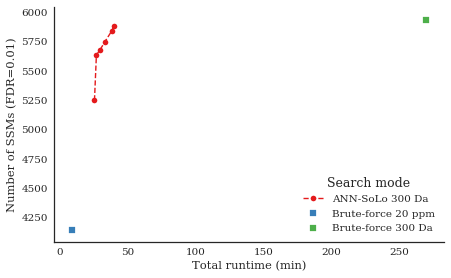

In [10]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

hp_ann = hyperparameters[hyperparameters['mode'] == 'ANN-SoLo']
hp_bf = hyperparameters[hyperparameters['mode'] == 'Brute-force']

# ANN timing
hp_ann_pareto = get_pareto_frontier(hp_ann[['time', 'psms']].values)
plt.plot(hp_ann_pareto[:, 0], hp_ann_pareto[:, 1], '--o',
         label='ANN-SoLo 300 Da')

# empty scatter to advance the color cycler
plt.scatter([], [])

# brute-force closed & open timing
for _, row in hp_bf.iterrows():
    plt.scatter(row['time'], row['psms'], marker='s',
                label='{} {} {}'.format(row['mode'], row['precursor_tol_mass'],
                                      row['precursor_tol_mode']))

ax.set_xlabel('Total runtime (min)')
fdr = 0.01    # specified in the search settings
ax.set_ylabel('Number of SSMs (FDR={})'.format(fdr))

# ax.set_xscale('log', basex=2)

ax.legend(loc='lower right', title='Search mode')

sns.despine()

plt.savefig('ann_hyperparameters.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [11]:
# add information on tree construction
filename_build = os.path.join(out_dir, 'build_trees', 'build_trees.txt')
build_trees = pd.read_csv(filename_build, sep='\t')
build_trees['build_time'] = build_trees['build_time'] / 60
build_trees['size'] = build_trees['size'] / 1024
hyperparameters = hyperparameters.merge(build_trees, how='outer', on='num_trees')

In [12]:
table_latex = hyperparameters.copy()
# use pretty column names
table_latex['Search mode'] = (
    table_latex['mode'] + ' ' +
    table_latex['precursor_tol_mass'].map(str) + ' ' +
    table_latex['precursor_tol_mode'])
table_latex['num\_trees'] = table_latex['num_trees']
table_latex['Build time (\si{\minute})'] = table_latex['build_time'].map('{:,.1f}'.format)
table_latex['Index size (\si{\giga\\byte})'] = table_latex['size'].map('{:,.2f}'.format)
table_latex['{search\_k}'] = table_latex['search_k']
table_latex['\#~SSMs'] = table_latex['psms']
table_latex['Search time (\si{\minute})'] = table_latex['time'].map('{:,.1f}'.format)
# remove duplicated column values for pretty LaTeX output
dup_columns = ['Search mode', 'num\_trees', 'Build time (\si{\minute})',
               'Index size (\si{\giga\\byte})']
table_latex.loc[table_latex.duplicated(dup_columns), dup_columns] = ''
table_latex.loc[table_latex['Search mode'].str.contains('Brute-force'),
                ['num\_trees', '{search\_k}', 'Build time (\si{\minute})',
                 'Index size (\si{\giga\\byte})']] = ''
table_latex = table_latex.drop([
    'mode', 'precursor_tol_mass', 'precursor_tol_mode', 'num_trees',
    'search_k', 'psms', 'time', 'build_time', 'size'], axis=1)
table_latex.to_latex(
    buf='../../reports/rev/tab-ann_hyperparameters.tex',
    index=False,
    column_format='lrrrS[table-format=6.0]rr',
    escape=False)

In [13]:
logging.shutdown()